In [1]:
import copy
import random
from collections import defaultdict

import numpy as np
import tqdm
from IPython import display
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

import jax
import jax.numpy as jnp
import flax.linen as nn
import optax

In [2]:
class RiverSwim:
    def __init__(self, current='WEAK', seed=1234, max_episode_steps=1001):
        self.num_states = 6
        self.num_actions = 2  # O <=> LEFT, 1 <=> RIGHT
        self.max_episode_steps = max_episode_steps

        # Larger current makes it harder to swim up the river
        self.currents = ['WEAK', 'MEDIUM', 'STRONG']
        assert current in self.currents
        self.current = self.currents.index(current) + 1
        assert self.current in [1, 2, 3]

        # Configure reward function
        R = np.zeros((self.num_states, self.num_actions, self.num_states))
        R[0, 0, 0] = 0.005
        R[5, 1, 5] = 1.0

        # Configure transition function
        T = np.zeros((self.num_states, self.num_actions, self.num_states))

        # Encode initial and rewarding state transitions
        left, right = 0, 1
        T[0, left, 0] = 1.
        T[0, right, 0] = 0.4
        T[0, right, 1] = 0.6

        T[5, left, 4] = 1.
        T[5, right, 5] = 0.6
        T[5, right, 4] = 0.4

        # Encode intermediate state transitions
        for s in range(1, self.num_states - 1):
            # Going left always succeeds
            T[s, left, s - 1] = 1.

            # Going right sometimes succeeds
            T[s, right, s] = 0.6
            T[s, right, s - 1] = 0.05 * self.current
            T[s, right, s + 1] = 0.4 - 0.05 * self.current
            assert np.isclose(np.sum(T[s, right]), 1.)

        self.R = np.array(R)
        self.T = np.array(T)

        self.reset()
        # self.timestep = 0
        # self.init_state = np.random.randint(self.num_states)
        # self.curr_state = self.init_state

        self.seed = seed
        random.seed(self.seed)
        np.random.seed(self.seed)

    def get_model(self):
        return copy.deepcopy(self.R), copy.deepcopy(self.T)

    def reset(self):
        self.timestep = 0
        self.init_state = np.random.randint(self.num_states)
        self.curr_state = self.init_state
        return self.curr_state

    def step(self, action):
        next_state = np.random.choice(np.arange(self.num_states), p=self.T[self.curr_state, action])
        reward = self.R[self.curr_state, action, next_state]
        self.curr_state = next_state
        
        terminated = False
        self.timestep += 1
        truncated = (self.timestep >= self.max_episode_steps)
        
        return reward, next_state, terminated, truncated


In [3]:
# collect dataset
seed = 100
discount = 0.99
max_episode_steps = 1001
env = RiverSwim(seed=seed, max_episode_steps=max_episode_steps)

# uniform behavioral policy
behavioral_policy = np.ones([env.num_states, env.num_actions]) / env.num_actions

dataset = defaultdict(list)

# dataset size = 100K
num_episodes = 100
num_transitions = 0
for _ in tqdm.trange(num_episodes):
    done = False
    obs = env.reset()
    while not done:
        action = np.random.choice(np.arange(env.num_actions), p=behavioral_policy[obs])
        reward, next_obs, terminated, truncated = env.step(action)
        done = terminated or truncated
        
        num_transitions += 1
        dataset['observations'].append(obs)
        dataset['actions'].append(action)
        dataset['rewards'].append(reward)
        dataset['masks'].append(not terminated)  # for absorbing states
        dataset['terminals'].append(done)  # for the end of trajectori
        
        obs = next_obs

for k, v in dataset.items():
    if 'observations' in k or 'actions' in k:
        dtype = np.int32
    elif k == 'terminals':
        dtype = bool
    else:
        dtype = np.float32
    dataset[k] = np.array(v, dtype=dtype)

train_dataset = dict()
ob_mask = (1.0 - dataset['terminals']).astype(bool)
next_ob_mask = np.concatenate([[False], ob_mask[:-1]])
train_dataset['observations'] = dataset['observations'][ob_mask]
train_dataset['next_observations'] = dataset['observations'][next_ob_mask]
train_dataset['actions'] = dataset['actions'][ob_mask]
train_dataset['next_actions'] = dataset['actions'][next_ob_mask]
train_dataset['rewards'] = dataset['rewards'][ob_mask]
new_masks = np.concatenate([dataset['masks'][1:], [0.0]])
train_dataset['masks'] = new_masks[ob_mask].astype(np.float32)
new_terminals = np.concatenate([dataset['terminals'][1:], [1.0]])
train_dataset['terminals'] = new_terminals[ob_mask].astype(np.float32)


# dataset size = 100K
dataset_size = 100_000
print("num of total transitions {}".format(train_dataset['observations'].shape[0]))

assert train_dataset['observations'].shape[0] >= dataset_size
for k, v in train_dataset.items():
    train_dataset[k] = v[:dataset_size]

print("num of transitions in the dataset: {}".format(train_dataset['observations'].shape[0]))

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:03<00:00, 29.16it/s]


num of total transitions 100000
num of transitions in the dataset: 100000


In [58]:
# value iteration to find the optimal Q
rewards, transition_probs = env.get_model()

opt_q = np.zeros([env.num_states, env.num_actions], dtype=np.float32)
for _ in range(10_000):
  opt_q = (1 - discount) * np.sum(transition_probs * rewards, axis=-1) + discount * np.einsum('ijk,k->ij', transition_probs, np.max(opt_q, axis=-1))
opt_v = np.max(opt_q, axis=-1)

# deterministic optimal policy
opt_policy = np.zeros([env.num_states, env.num_actions])
opt_policy[np.arange(env.num_states), np.argmax(opt_q, axis=-1)] = 1.0

# value iteration to find the behavioral Q
rewards, transition_probs = env.get_model()

behavioral_q = np.zeros([env.num_states, env.num_actions], dtype=np.float32)
for _ in range(10_000):
  behavioral_q = (1 - discount) * np.sum(transition_probs * rewards, axis=-1) + discount * np.einsum('ijk,k->ij', transition_probs, np.sum(behavioral_policy * behavioral_q, axis=-1))
behavioral_v = np.sum(behavioral_policy * behavioral_q, axis=-1)

In [4]:
print("optimal q and optimal policy: ")
print(opt_q)
print(opt_policy)

print("behavioral q: ")
print(behavioral_q)

optimal q and optimal policy: 


NameError: name 'opt_q' is not defined

### Augmented env

In [6]:
class AugmentedRiverSwim:
    def __init__(self, discount=0.99, current='WEAK', seed=1234, max_episode_steps=1001):
        self.num_states = 6 + 2  # add s_plus and s_minus
        self.num_actions = 2  # O <=> LEFT, 1 <=> RIGHT
        self.max_episode_steps = max_episode_steps
        
        self.discount = discount
        # Larger current makes it harder to swim up the river
        self.currents = ['WEAK', 'MEDIUM', 'STRONG']
        assert current in self.currents
        self.current = self.currents.index(current) + 1
        assert self.current in [1, 2, 3]

        # Configure reward function
        left, right = 0, 1
        orig_R = np.zeros((self.num_states, self.num_actions, self.num_states))
        orig_R[0, 0, 0] = 0.005
        orig_R[self.num_states - 3, 1, self.num_states - 3] = 1.0

        # Configure transition function
        T = np.zeros((self.num_states, self.num_actions, self.num_states))

        # Encode initial and rewarding state transitions
        T[0, left, 0] = 1.
        T[0, right, 0] = 0.4
        T[0, right, 1] = 0.6

        T[self.num_states - 3, left, self.num_states - 4] = 1.
        T[self.num_states - 3, right, self.num_states - 3] = 0.6
        T[self.num_states - 3, right, self.num_states - 4] = 0.4

        # Encode intermediate state transitions
        for s in range(1, self.num_states - 3):
            # Going left always succeeds
            T[s, left, s - 1] = 1.

            # Going right sometimes succeeds
            T[s, right, s] = 0.6
            T[s, right, s - 1] = 0.05 * self.current
            T[s, right, s + 1] = 0.4 - 0.05 * self.current
            assert np.isclose(np.sum(T[s, right]), 1.)

        # transite to s+ and s- using r(s, a)
        T[:self.num_states - 2, :, self.num_states - 2] = (1. - discount) * np.sum(orig_R[:self.num_states - 2] * T[:self.num_states - 2], axis=-1)
        T[:self.num_states - 2, :, self.num_states - 1] = (1. - discount) * (1. - np.sum(orig_R[:self.num_states - 2] * T[:self.num_states - 2], axis=-1))
        
        # discount every transitions in the original MDP
        T[:self.num_states - 2, :, :self.num_states - 2] *= discount
        
        T[self.num_states - 2, left, self.num_states - 2] = 1.
        T[self.num_states - 2, right, self.num_states - 2] = 1.
        T[self.num_states - 1, left, self.num_states - 1] = 1.
        T[self.num_states - 1, right, self.num_states - 1] = 1.
        
        assert np.all(np.isclose(np.sum(T, axis=-1), 1.))
        
        R = np.zeros((self.num_states, self.num_actions, self.num_states))
        # R[:self.num_states - 2, :, self.num_states - 2] = 1.0  # transit to s+ from states in the original MDP gives us reward
        R[..., self.num_states - 2] = 1.0  # transit to s+ from any states in the augmented GCMDP gives us reward
        # R[6] = 1.0  # only s+ in the augmented GCMDP gives us reward
        self.R = np.asarray(R)
        self.T = np.asarray(T)

        self.reset()
        # selr.timestep = 0
        # self.init_state = 0
        # self.curr_state = self.init_state

        self.seed = seed
        random.seed(self.seed)
        np.random.seed(self.seed)

    def get_model(self):
        return copy.deepcopy(self.R), copy.deepcopy(self.T)

    def reset(self):
        # the initial state distribution is the same as the original MDP
        self.timestep = 0
        self.init_state = np.random.randint(self.num_states - 2)
        self.curr_state = self.init_state
        return self.curr_state
    
    def step(self, action):
        terminated = (self.curr_state == self.num_states - 2) or (self.curr_state == self.num_states - 1)
        
        next_state = np.random.choice(np.arange(self.num_states), p=self.T[self.curr_state, action])
        reward = self.R[self.curr_state, action, next_state]
        self.curr_state = next_state
        
        self.timestep += 1
        truncated = (self.timestep >= self.max_episode_steps)
        
        return reward, next_state, terminated, truncated


In [17]:
# collect dataset
seed = 100
discount = 0.99
max_episode_steps = 1001
augmented_env = AugmentedRiverSwim(discount=discount, seed=seed, max_episode_steps=max_episode_steps)

# optimal behavioral policy with noise
# behavioral_policy = np.ones([augmented_env.num_states, augmented_env.num_actions]) / augmented_env.num_actions
noisy_action_prob = 0.05
behavioral_policy = np.zeros([augmented_env.num_states, augmented_env.num_actions])
behavioral_policy[:, 1] = 1.

augmented_dataset = defaultdict(list)

num_episodes = 1_011
num_transitions = 0
for _ in tqdm.trange(num_episodes):
    done = False
    obs = augmented_env.reset()
    while not done:
        action = np.random.choice(np.arange(augmented_env.num_actions), p=behavioral_policy[obs])
        if np.random.rand() < noisy_action_prob:
            action = 1 - action
        reward, next_obs, terminated, truncated = augmented_env.step(action)
        done = terminated or truncated
        
        num_transitions += 1
        augmented_dataset['observations'].append(obs)
        augmented_dataset['actions'].append(action)
        augmented_dataset['rewards'].append(reward)
        augmented_dataset['masks'].append(not terminated)  # for absorbing states
        augmented_dataset['terminals'].append(done)  # for the end of trajectori
        
        obs = next_obs

for k, v in augmented_dataset.items():
    if k in ['observations', 'actions']:
        dtype = np.int32
    elif k in ['masks', 'terminals']:
        dtype = bool
    else:
        dtype = np.float32
    augmented_dataset[k] = np.array(v, dtype=dtype)

augmented_train_dataset = dict()
ob_mask = (1.0 - augmented_dataset['terminals']).astype(bool)
next_ob_mask = np.concatenate([[False], ob_mask[:-1]])
augmented_train_dataset['observations'] = augmented_dataset['observations'][ob_mask]
augmented_train_dataset['next_observations'] = augmented_dataset['observations'][next_ob_mask]
augmented_train_dataset['actions'] = augmented_dataset['actions'][ob_mask]
augmented_train_dataset['next_actions'] = augmented_dataset['actions'][next_ob_mask]
augmented_train_dataset['rewards'] = augmented_dataset['rewards'][ob_mask]
new_masks = np.concatenate([augmented_dataset['masks'][1:], [0.0]])
augmented_train_dataset['masks'] = new_masks[ob_mask].astype(np.float32)  # where the observations are absorbing states
new_terminals = np.concatenate([augmented_dataset['terminals'][1:], [1.0]])
augmented_train_dataset['terminals'] = new_terminals[ob_mask].astype(np.float32)

# dataset size = 100K
dataset_size = 100_000
print(augmented_train_dataset['observations'].shape[0])

# assert augmented_train_dataset['observations'].shape[0] >= dataset_size
# for k, v in augmented_train_dataset.items():
#     augmented_train_dataset[k] = v[:dataset_size]

print("num of augmented transitions: {}".format(augmented_train_dataset['observations'].shape[0]))

  0%|          | 0/1011 [00:00<?, ?it/s]

100%|██████████| 1011/1011 [00:03<00:00, 285.43it/s]

100084
num of augmented transitions: 100084


In [18]:
# print(np.where(augmented_train_dataset['masks'] == False))
# print(np.where(augmented_train_dataset['observations'] == 6))

# print(augmented_train_dataset['observations'][112])
print(np.sum(augmented_train_dataset['observations'] == 6))
print(np.sum(augmented_train_dataset['next_observations'] == 6))
print(np.sum(augmented_train_dataset['observations'] == 7))
print(np.sum(augmented_train_dataset['next_observations'] == 7))
print(np.sum(augmented_train_dataset['rewards']))

0
190
0
821
190.0


In [19]:
print(augmented_env.get_model()[1][0, 0])
print(augmented_env.get_model()[1][1, 0])
print(augmented_env.get_model()[1][2, 0])
print(augmented_env.get_model()[1][3, 0])
print(augmented_env.get_model()[1][4, 0])
print(augmented_env.get_model()[1][5, 0])
print(augmented_env.get_model()[1][6, 0])
print(augmented_env.get_model()[1][7, 0])

print("---")
print(augmented_env.get_model()[1][0, 1])
print(augmented_env.get_model()[1][1, 1])
print(augmented_env.get_model()[1][2, 1])
print(augmented_env.get_model()[1][3, 1])
print(augmented_env.get_model()[1][4, 1])
print(augmented_env.get_model()[1][5, 1])
print(augmented_env.get_model()[1][6, 1])
print(augmented_env.get_model()[1][7, 1])

print("---")
print(augmented_env.get_model()[0])

[9.90e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 5.00e-05 9.95e-03]
[0.99 0.   0.   0.   0.   0.   0.   0.01]
[0.   0.99 0.   0.   0.   0.   0.   0.01]
[0.   0.   0.99 0.   0.   0.   0.   0.01]
[0.   0.   0.   0.99 0.   0.   0.   0.01]
[0.   0.   0.   0.   0.99 0.   0.   0.01]
[0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 1.]
---
[0.396 0.594 0.    0.    0.    0.    0.    0.01 ]
[0.0495 0.594  0.3465 0.     0.     0.     0.     0.01  ]
[0.     0.0495 0.594  0.3465 0.     0.     0.     0.01  ]
[0.     0.     0.0495 0.594  0.3465 0.     0.     0.01  ]
[0.     0.     0.     0.0495 0.594  0.3465 0.     0.01  ]
[0.    0.    0.    0.    0.396 0.594 0.006 0.004]
[0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 1.]
---
[[[0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0.]]

 [[0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0.]]

 [[0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0.]]

 [[0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0.]]

 [[0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 

In [20]:
# value iteration to find the optimal Q in the MDP using gamma ** 2
rewards, transition_probs = env.get_model()

opt_q_square_discount = np.zeros([env.num_states, env.num_actions], dtype=np.float32)
for _ in range(10_000):
  opt_q_square_discount = (1 - discount ** 2) * np.sum(rewards * transition_probs, axis=-1) + discount ** 2 * np.einsum('ijk,k->ij', transition_probs, np.max(opt_q_square_discount, axis=-1))

In [21]:
# value iteration to find the optimal discounted state occupancy measure in the GCMDP using gamma
rewards, transition_probs = augmented_env.get_model()

opt_d_sa = np.zeros([augmented_env.num_states, augmented_env.num_actions, augmented_env.num_states], dtype=np.float32)
for _ in range(10_000):
  opt_a = np.argmax(opt_d_sa[..., augmented_env.num_states - 2], axis=-1)
  opt_pi = np.zeros((augmented_env.num_states, augmented_env.num_actions))
  opt_pi[np.arange(augmented_env.num_states), opt_a] = 1.
  # opt_d_sa = (1 - discount) * np.eye(augmented_env.num_states)[:, None] + discount * np.einsum('ijk,kl->ijl', transition_probs, np.sum(opt_d_sa * opt_pi[..., None], axis=1))
  opt_d_sa = (1 - discount) * np.eye(augmented_env.num_states)[:, None] + discount * np.einsum('ijk,kl->ijl', transition_probs, np.sum(opt_d_sa * opt_pi[..., None], axis=1))

opt_a = np.argmax(opt_d_sa[..., augmented_env.num_states - 2], axis=-1)
opt_pi = np.zeros((augmented_env.num_states, augmented_env.num_actions))
opt_pi[np.arange(augmented_env.num_states), opt_a] = 1.

opt_d_s = np.sum(opt_d_sa * opt_pi[..., None], axis=1)

In [22]:
print("scaled optimal d_gamma(s+ | s, a) and optimal policy: ")
scaled_opt_d_sa_splus = opt_d_sa[..., augmented_env.num_states - 2] * (1 + discount) / discount
print(scaled_opt_d_sa_splus)
print(opt_pi)

print("optimal Q_gamma^2(s, a): ")
print(opt_q_square_discount)

assert np.allclose(scaled_opt_d_sa_splus[:augmented_env.num_states - 2], opt_q_square_discount)

scaled optimal d_gamma(s+ | s, a) and optimal policy: 
[[0.1972363  0.20113947]
 [0.1971368  0.20794605]
 [0.20380792 0.2209817 ]
 [0.21658416 0.23566343]
 [0.23097373 0.25143202]
 [0.24642853 0.26827065]
 [2.01010101 2.01010101]
 [0.         0.        ]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]
optimal Q_gamma^2(s, a): 
[[0.1972363  0.20113947]
 [0.1971368  0.20794605]
 [0.20380792 0.2209817 ]
 [0.21658416 0.23566343]
 [0.23097373 0.25143202]
 [0.24642853 0.26827065]]


In [23]:
# evaluation the optimal pi
seed = 100
max_episode_steps = 1001
augmented_eval_env = AugmentedRiverSwim(discount=discount, seed=seed, max_episode_steps=max_episode_steps)

num_episodes = 2000
successes = []
for _ in tqdm.trange(num_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs = augmented_eval_env.reset()
    while not done:
        action = np.random.choice(np.arange(augmented_eval_env.num_actions), p=opt_pi[obs])
        reward, next_obs, terminated, truncated = augmented_eval_env.step(action)
        done = terminated or truncated
        
        traj_dataset['observations'].append(obs)
        traj_dataset['actions'].append(action)
        traj_dataset['rewards'].append(reward)
        
        obs = next_obs
    successes.append(np.sum(traj_dataset['rewards']) >= 1.0)

sr = np.mean(successes)
print("success rate = {}".format(sr))


100%|██████████| 2000/2000 [00:06<00:00, 306.58it/s]

success rate = 0.252


In [24]:
# value iteration to compute the optimal single goal-conditioned Q in the GCMDP using gamma
rewards, transition_probs = augmented_env.get_model()

opt_gc_q = np.zeros([augmented_env.num_states, augmented_env.num_actions], dtype=np.float32)
for _ in range(10_000):
  opt_gc_q = (1 - discount) * np.sum(rewards * transition_probs, axis=-1) + discount * np.einsum('ijk,k->ij', transition_probs, np.max(opt_gc_q, axis=-1))
indicators = np.zeros((augmented_env.num_states, augmented_env.num_actions))
indicators[augmented_env.num_states - 2] = 1.
scaled_opt_gc_q = opt_gc_q * discount + indicators * (1 - discount)
scaled_opt_gc_q = scaled_opt_gc_q * (1 + discount) / discount

assert np.allclose(scaled_opt_d_sa_splus[:augmented_env.num_states - 2], scaled_opt_gc_q[:augmented_env.num_states - 2])
assert np.allclose(opt_q_square_discount, scaled_opt_gc_q[:augmented_env.num_states - 2])

print("optimal Q_gamma^2(s, a): ")
print(opt_q_square_discount)

print("scaled optimal goal-conditioned Q: ")
print(scaled_opt_gc_q[:env.num_states])

optimal Q_gamma^2(s, a): 
[[0.1972363  0.20113947]
 [0.1971368  0.20794605]
 [0.20380792 0.2209817 ]
 [0.21658416 0.23566343]
 [0.23097373 0.25143202]
 [0.24642853 0.26827065]]
scaled optimal goal-conditioned Q: 
[[0.1972363  0.20113947]
 [0.1971368  0.20794605]
 [0.20380792 0.2209817 ]
 [0.21658416 0.23566343]
 [0.23097373 0.25143202]
 [0.24642853 0.26827065]]


In [25]:
print(augmented_env.get_model()[1][0, 0])
print(augmented_env.get_model()[1][1, 0])
print(augmented_env.get_model()[1][2, 0])
print(augmented_env.get_model()[1][3, 0])
print(augmented_env.get_model()[1][4, 0])
print(augmented_env.get_model()[1][5, 0])
print(augmented_env.get_model()[1][6, 0])
print(augmented_env.get_model()[1][7, 0])

print("---")
print(augmented_env.get_model()[1][0, 1])
print(augmented_env.get_model()[1][1, 1])
print(augmented_env.get_model()[1][2, 1])
print(augmented_env.get_model()[1][3, 1])
print(augmented_env.get_model()[1][4, 1])
print(augmented_env.get_model()[1][5, 1])
print(augmented_env.get_model()[1][6, 1])
print(augmented_env.get_model()[1][7, 1])

print(augmented_env.get_model()[1][0, 0])
print(augmented_env.get_model()[1][1, 0])
print(augmented_env.get_model()[1][2, 0])
print(augmented_env.get_model()[1][3, 0])
print(augmented_env.get_model()[1][4, 0])
print(augmented_env.get_model()[1][5, 0])
print(augmented_env.get_model()[1][6, 0])
print(augmented_env.get_model()[1][7, 0])

print("---")
print(augmented_env.get_model()[1][0, 1])
print(augmented_env.get_model()[1][1, 1])
print(augmented_env.get_model()[1][2, 1])
print(augmented_env.get_model()[1][3, 1])
print(augmented_env.get_model()[1][4, 1])
print(augmented_env.get_model()[1][5, 1])
print(augmented_env.get_model()[1][6, 1])
print(augmented_env.get_model()[1][7, 1])

print("---")
print(augmented_env.get_model()[0])

[9.90e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 5.00e-05 9.95e-03]
[0.99 0.   0.   0.   0.   0.   0.   0.01]
[0.   0.99 0.   0.   0.   0.   0.   0.01]
[0.   0.   0.99 0.   0.   0.   0.   0.01]
[0.   0.   0.   0.99 0.   0.   0.   0.01]
[0.   0.   0.   0.   0.99 0.   0.   0.01]
[0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 1.]
---
[0.396 0.594 0.    0.    0.    0.    0.    0.01 ]
[0.0495 0.594  0.3465 0.     0.     0.     0.     0.01  ]
[0.     0.0495 0.594  0.3465 0.     0.     0.     0.01  ]
[0.     0.     0.0495 0.594  0.3465 0.     0.     0.01  ]
[0.     0.     0.     0.0495 0.594  0.3465 0.     0.01  ]
[0.    0.    0.    0.    0.396 0.594 0.006 0.004]
[0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 1.]
[9.90e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 5.00e-05 9.95e-03]
[0.99 0.   0.   0.   0.   0.   0.   0.01]
[0.   0.99 0.   0.   0.   0.   0.   0.01]
[0.   0.   0.99 0.   0.   0.   0.   0.01]
[0.   0.   0.   0.99 0.   0.   0.   0.01]
[0.   0.   0.   0.   0.99 0.   0. 

#### Utils

In [26]:
def sample_batch(batch_size):
    dataset_size = len(train_dataset['observations'])
    idxs = np.random.randint(dataset_size, size=batch_size)
    batch = jax.tree_util.tree_map(lambda arr: arr[idxs], train_dataset)
    
    return batch

In [27]:
(terminal_locs,) = np.nonzero(augmented_train_dataset['terminals'] > 0)
assert terminal_locs[-1] == (len(augmented_train_dataset['observations']) - 1)

def sample_augmented_batch(batch_size, p_curgoal=0.2, p_trajgoal=0.5, relabel_reward=False):
    dataset_size = len(augmented_train_dataset['observations'])
    idxs = np.random.randint(dataset_size, size=batch_size)
    batch = jax.tree_util.tree_map(lambda arr: arr[idxs], augmented_train_dataset)
    
    final_state_idxs = terminal_locs[np.searchsorted(terminal_locs, idxs)]
    
    offsets = np.random.geometric(p=1 - discount, size=batch_size)  # in [1, inf)
    traj_goal_idxs = np.minimum(idxs + offsets, final_state_idxs)
    random_goal_idxs = np.random.randint(dataset_size, size=batch_size)
    goal_idxs = np.where(
        np.random.rand(batch_size) < p_trajgoal / (1.0 - p_curgoal), traj_goal_idxs, random_goal_idxs
    )
    goal_idxs = np.where(np.random.rand(batch_size) < p_curgoal, idxs, goal_idxs)

    batch['goals'] = jax.tree_util.tree_map(lambda arr: arr[goal_idxs], augmented_train_dataset['observations'])
    if relabel_reward:
        successes = np.logical_or((idxs + 1) == goal_idxs, idxs == goal_idxs).astype(float)
        batch['masks'] = 1.0 - successes
        batch['rewards'] = successes
    
    return batch

In [28]:
def plot_metrics(metrics, logyscale_stats=[], title=''):
  # learning curves
  nrows = np.ceil(len(metrics) / 4).astype(int)
  ncols = 4
  f, axes = plt.subplots(nrows=nrows, ncols=ncols)
  if nrows == 1:
    axes = np.array([axes])
  f.set_figheight(3 * nrows)
  f.set_figwidth(3 * ncols)

  for idx, (name, val) in enumerate(metrics.items()):
    v = np.array(val)
    if len(v) == 0:
      continue

    x, y = v[:, 0], v[:, 1]
    ax = axes[idx // 4, idx % 4]

    if 'train' in name:
      y = gaussian_filter1d(y, 100)
    ax.plot(x, y)
    if name in logyscale_stats:
      ax.set_yscale('log')
    ax.set_title(name)

    ax.grid()

  f.suptitle(title)

  return f

### Q-Learning

In [29]:
class Critic(nn.Module):
  @nn.compact
  def __call__(self, obs, action):
    obs = jax.nn.one_hot(obs, env.num_states)
    action = jax.nn.one_hot(action, env.num_actions)
    inputs = jnp.concatenate([obs, action], axis=-1)

    qs = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(1),
    ])(inputs)
    
    qs = qs.squeeze(-1)

    return qs

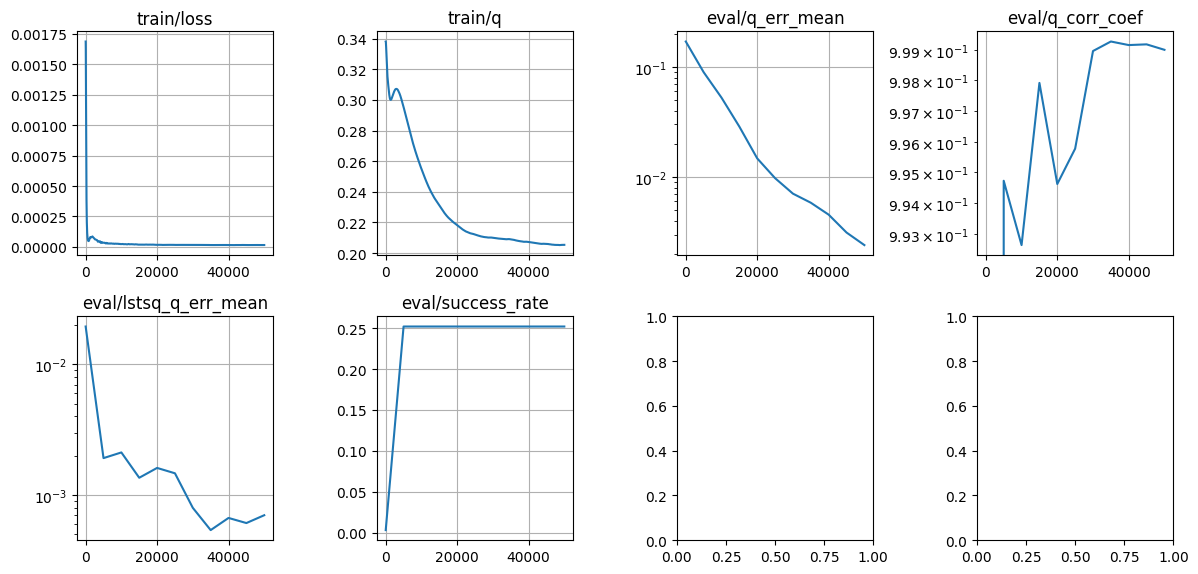

100%|██████████| 50000/50000 [02:19<00:00, 358.70it/s] 


In [30]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_batch(2)
critic = Critic()
critic_params = critic.init(critic_key, example_batch['observations'], example_batch['actions'])
target_critic_params = copy.deepcopy(critic_params)

def loss_fn(params, target_params, batch):
  q = critic.apply(params, batch['observations'], batch['actions'])
  
  next_q1 = critic.apply(target_params, batch['next_observations'], jnp.zeros_like(batch['next_observations']))
  next_q2 = critic.apply(target_params, batch['next_observations'], jnp.ones_like(batch['next_observations']))
  next_q = jnp.maximum(next_q1, next_q2)
  target_q = (1 - discount ** 2) * batch['rewards'] + discount ** 2 * batch['masks'] * next_q

  loss = jnp.mean((q - target_q) ** 2)
  
  info = {
    'loss': loss,
    'q': q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def compute_success_rate(params, num_eval_episodes=2000, max_episode_steps=1001):
  seed = 100
  augmented_eval_env = AugmentedRiverSwim(discount=discount, seed=seed, max_episode_steps=max_episode_steps)
  
  # compute the pi
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  q = critic.apply(params, obs, actions)
  q = q.reshape([augmented_env.num_states, augmented_env.num_actions])
  a = jnp.argmax(q, axis=-1)
  pi = jax.nn.one_hot(a, augmented_env.num_actions)
  pi = np.asarray(pi)

  # evaluation
  successes = []
  for _ in tqdm.trange(num_eval_episodes):
      traj_dataset = defaultdict(list)

      done = False
      obs = augmented_eval_env.reset()
      while not done:
          action = np.random.choice(np.arange(augmented_eval_env.num_actions), p=pi[obs])
          reward, next_obs, terminated, truncated = augmented_eval_env.step(action)
          done = terminated or truncated
          
          traj_dataset['observations'].append(obs)
          traj_dataset['actions'].append(action)
          traj_dataset['rewards'].append(reward)
          
          obs = next_obs
      successes.append(np.sum(traj_dataset['rewards']) >= 1.0)

  sr = np.mean(successes)

  return sr

def evaluate_fn(params):
  obs = jnp.arange(env.num_states)[:, None].repeat(env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(env.num_actions)[None, :].repeat(env.num_states, axis=0).reshape(-1)
  q = critic.apply(params, obs, actions)
  q = q.reshape([env.num_states, env.num_actions])
  # scaled_q = q * (opt_q_square_discount / q).mean()
  # q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  # scaled_q_err_mean = jnp.mean(np.abs(scaled_q - opt_q_square_discount))
  # q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q_square_discount.reshape(-1)
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q_square_discount))
  
  sr = compute_success_rate(params)
  
  info = {
    'q_err_mean': q_err_mean,
    'q_corr_coef': q_corr_coef,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'success_rate': sr,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_batch(batch_size)
  critic_params, target_critic_params, opt_state, loss, info = update_fn(
    critic_params, target_critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/q_corr_coef', 'eval/lstsq_q_err_mean'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [31]:
q_learning_metrics = metrics
print(q_learning_metrics['eval/q_err_mean'][-1])
print(q_learning_metrics['eval/q_corr_coef'][-1])
print(q_learning_metrics['eval/lstsq_q_err_mean'][-1])
print(q_learning_metrics['eval/success_rate'][-1])

[5.00000000e+04 2.41023186e-03]
[5.00000000e+04 9.98998523e-01]
[5.00000000e+04 7.01516867e-04]
[5.00e+04 2.52e-01]


### SGCQL

In [32]:
class Critic(nn.Module):
  @nn.compact
  def __call__(self, obs, action):
    obs = jax.nn.one_hot(obs, augmented_env.num_states)
    action = jax.nn.one_hot(action, augmented_env.num_actions)
    inputs = jnp.concatenate([obs, action], axis=-1)
    
    qs = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(1),
    ])(inputs)
    
    qs = qs.squeeze(-1)

    return qs

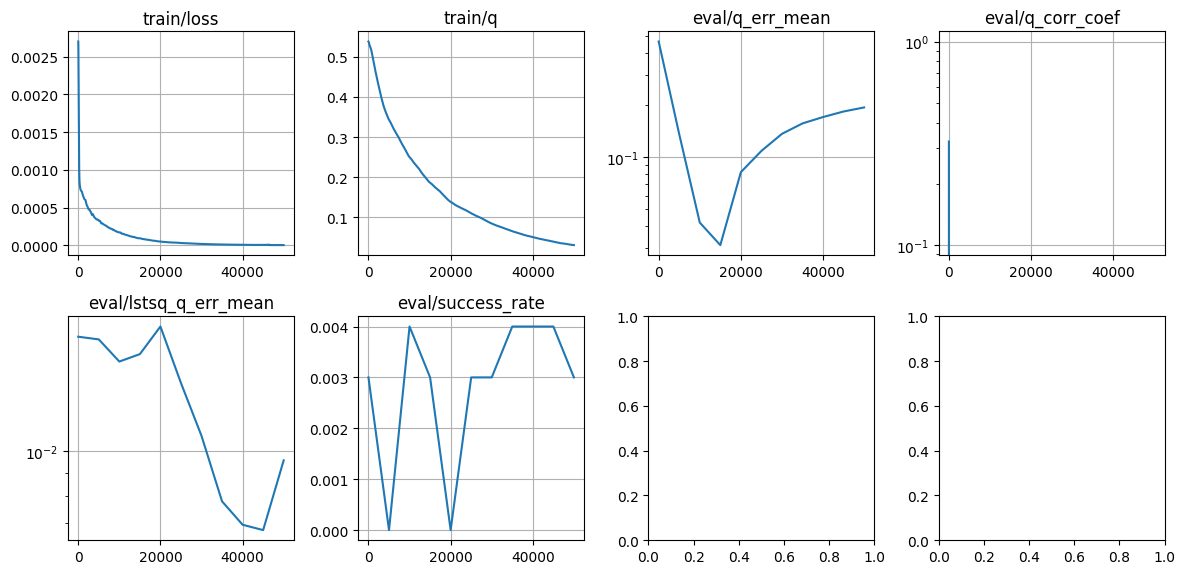

100%|██████████| 50000/50000 [02:32<00:00, 328.17it/s]


In [33]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

indicators = np.zeros((augmented_env.num_states, augmented_env.num_actions))
indicators[augmented_env.num_states - 2] = 1.
indicators = jnp.asarray(indicators)

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_augmented_batch(2)
critic = Critic()
critic_params = critic.init(critic_key, example_batch['observations'], example_batch['actions'])
target_critic_params = copy.deepcopy(critic_params)

def loss_fn(params, target_params, batch):
  q = critic.apply(params, batch['observations'], batch['actions'])
  
  next_q1 = critic.apply(target_params, batch['next_observations'], jnp.zeros_like(batch['next_observations']))
  next_q2 = critic.apply(target_params, batch['next_observations'], jnp.ones_like(batch['next_observations']))
  next_q = jnp.maximum(next_q1, next_q2)
  target_q = (1 - discount) * batch['rewards'] + discount * batch['masks'] * next_q

  loss = jnp.mean((q - target_q) ** 2)
  
  scaled_q = q * discount + indicators[batch['observations'], batch['actions']] * (1 - discount)
  scaled_q = scaled_q * (1 + discount) / discount
  
  info = {
    'loss': loss,
    'q': scaled_q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def compute_success_rate(params, num_eval_episodes=2000, max_episode_steps=1001):
  seed = 100
  augmented_eval_env = AugmentedRiverSwim(discount=discount, seed=seed, max_episode_steps=max_episode_steps)
  
  # compute the pi
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  q = critic.apply(params, obs, actions)
  q = q.reshape([augmented_env.num_states, augmented_env.num_actions])
  a = jnp.argmax(q, axis=-1)
  pi = jax.nn.one_hot(a, augmented_env.num_actions)
  pi = np.asarray(pi)

  # evaluation
  successes = []
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs = augmented_eval_env.reset()
    while not done:
      action = np.random.choice(np.arange(augmented_eval_env.num_actions), p=pi[obs])
      reward, next_obs, terminated, truncated = augmented_eval_env.step(action)
      done = terminated or truncated
      
      traj_dataset['observations'].append(obs)
      traj_dataset['actions'].append(action)
      traj_dataset['rewards'].append(reward)
      
      obs = next_obs
    successes.append(np.sum(traj_dataset['rewards']) >= 1.0)

  sr = np.mean(successes)

  return sr

def evaluate_fn(params):
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  gc_q = critic.apply(params, obs, actions)
  gc_q = gc_q.reshape([augmented_env.num_states, augmented_env.num_actions])
  # q = gc_q[:env.num_states]
  # q = q * (1 + discount) / discount
  scaled_gc_q = gc_q * discount + indicators * (1 - discount)
  scaled_gc_q = scaled_gc_q * (1 + discount) / discount
  q = scaled_gc_q[:env.num_states]
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q_square_discount.reshape(-1)
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q_square_discount))
  
  sr = compute_success_rate(params)
  
  info = {
    'q_err_mean': q_err_mean,
    'q_corr_coef': q_corr_coef,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'success_rate': sr,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_augmented_batch(batch_size)
  critic_params, target_critic_params, opt_state, loss, info = update_fn(
    critic_params, target_critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/q_corr_coef', 'eval/lstsq_q_err_mean'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [36]:
sgcql_metrics = metrics
print(sgcql_metrics['eval/q_err_mean'][-1])
print(sgcql_metrics['eval/q_corr_coef'][-1])
print(sgcql_metrics['eval/lstsq_q_err_mean'][-1])
print(sgcql_metrics['eval/success_rate'][-1])

[5.0000000e+04 1.9415383e-01]
[ 5.0000000e+04 -8.4401983e-01]
[5.00000000e+04 9.56703164e-03]
[5.e+04 3.e-03]


In [37]:
# evaluation the pi
obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
gc_q = critic.apply(critic_params, obs, actions)
gc_q = gc_q.reshape([augmented_env.num_states, augmented_env.num_actions])
gc_a = jnp.argmax(gc_q, axis=-1)
pi = jax.nn.one_hot(gc_a, augmented_env.num_actions)
pi = np.asarray(pi)

print("pi: ")
print(pi)


pi: 
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


### GCQL + HER

In [38]:
class Critic(nn.Module):
  @nn.compact
  def __call__(self, obs, action, goals):
    obs = jax.nn.one_hot(obs, augmented_env.num_states)
    action = jax.nn.one_hot(action, augmented_env.num_actions)
    goals = jax.nn.one_hot(goals, augmented_env.num_states)
    inputs = jnp.concatenate([obs, action, goals], axis=-1)

    qs = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(1),
    ])(inputs)
    
    qs = qs.squeeze(-1)

    return qs

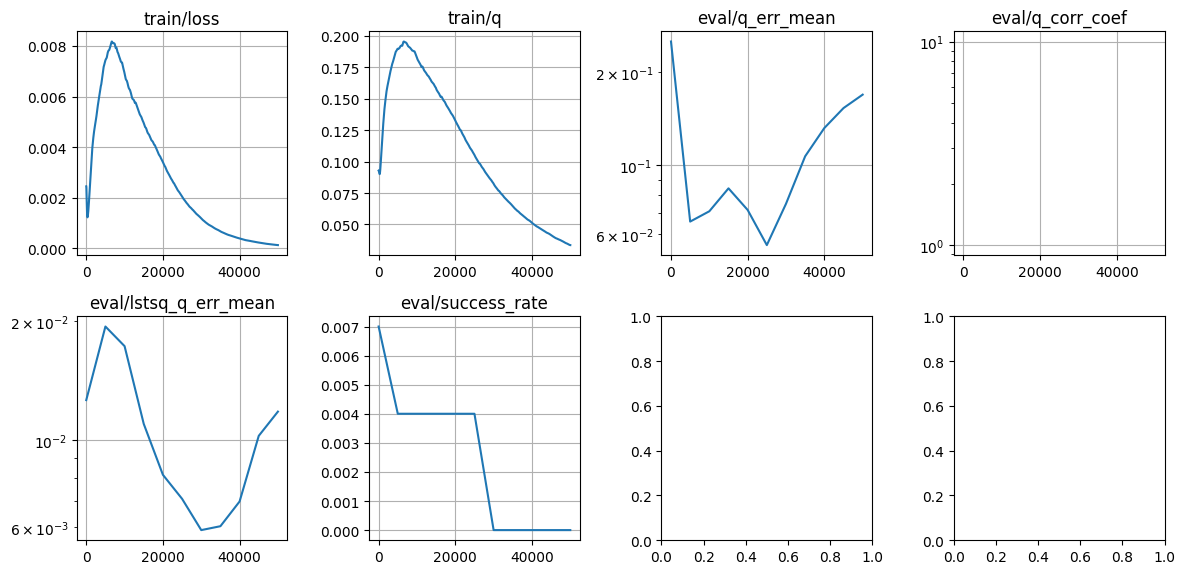

100%|██████████| 50000/50000 [02:36<00:00, 320.19it/s]


In [39]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

indicators = np.zeros((augmented_env.num_states, augmented_env.num_actions))
indicators[augmented_env.num_states - 2] = 1.
indicators = jnp.asarray(indicators)

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_augmented_batch(2, relabel_reward=True)
critic = Critic()
critic_params = critic.init(critic_key, 
                            example_batch['observations'], 
                            example_batch['actions'], 
                            example_batch['goals'])
target_critic_params = copy.deepcopy(critic_params)

def loss_fn(params, target_params, batch):
  q = critic.apply(params, batch['observations'], batch['actions'], batch['goals'])
  
  next_q1 = critic.apply(target_params, batch['next_observations'], jnp.zeros_like(batch['next_observations']), batch['goals'])
  next_q2 = critic.apply(target_params, batch['next_observations'], jnp.ones_like(batch['next_observations']), batch['goals'])
  next_q = jnp.maximum(next_q1, next_q2)
  target_q = (1 - discount) * batch['rewards'] + discount * batch['masks'] * next_q

  loss = jnp.mean((q - target_q) ** 2)

  # for logging
  gc_q = critic.apply(params, batch['observations'], batch['actions'], (augmented_env.num_states - 2) * jnp.ones_like(batch['goals']))  
  scaled_gc_q = gc_q * discount + indicators[batch['observations'], batch['actions']] * (1 - discount)
  scaled_gc_q = scaled_gc_q * (1 + discount) / discount
  
  info = {
    'loss': loss,
    'q': q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def compute_success_rate(params, num_eval_episodes=2000, max_episode_steps=1001):
  seed = 100
  augmented_eval_env = AugmentedRiverSwim(discount=discount, seed=seed, max_episode_steps=max_episode_steps)
  
  # compute the pi
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  q = critic.apply(params, obs, actions, (augmented_env.num_states - 2) * jnp.ones_like(obs))
  q = q.reshape([augmented_env.num_states, augmented_env.num_actions])
  a = jnp.argmax(q, axis=-1)
  pi = jax.nn.one_hot(a, augmented_env.num_actions)
  pi = np.asarray(pi)

  # evaluation
  successes = []
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs = augmented_eval_env.reset()
    while not done:
      action = np.random.choice(np.arange(augmented_eval_env.num_actions), p=pi[obs])
      reward, next_obs, terminated, truncated = augmented_eval_env.step(action)
      done = terminated or truncated
      
      traj_dataset['observations'].append(obs)
      traj_dataset['actions'].append(action)
      traj_dataset['rewards'].append(reward)
      
      obs = next_obs
    successes.append(np.sum(traj_dataset['rewards']) >= 1.0)

  sr = np.mean(successes)

  return sr

def evaluate_fn(params):
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  gc_q = critic.apply(params, obs, actions, (augmented_env.num_states - 2) * jnp.ones_like(obs))
  gc_q = gc_q.reshape([augmented_env.num_states, augmented_env.num_actions])
  # q = gc_q[:env.num_states]
  # q = q * (1 + discount) / discount
  scaled_gc_q = gc_q * discount + indicators * (1 - discount)
  scaled_gc_q = scaled_gc_q * (1 + discount) / discount
  q = scaled_gc_q[:env.num_states]
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q_square_discount.reshape(-1)
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q_square_discount))
  
  sr = compute_success_rate(params)
  
  info = {
    'q_err_mean': q_err_mean,
    'q_corr_coef': q_corr_coef,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'success_rate': sr,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_augmented_batch(batch_size, relabel_reward=True)
  critic_params, target_critic_params, opt_state, loss, info = update_fn(
    critic_params, target_critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/q_corr_coef', 'eval/lstsq_q_err_mean'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [40]:
gcql_her_metrics = metrics
print(gcql_her_metrics['eval/q_err_mean'][-1])
print(gcql_her_metrics['eval/q_corr_coef'][-1])
print(gcql_her_metrics['eval/lstsq_q_err_mean'][-1])
print(gcql_her_metrics['eval/success_rate'][-1])

[5.000000e+04 1.690301e-01]
[ 5.00000000e+04 -7.98020065e-01]
[5.00000000e+04 1.17807575e-02]
[50000.     0.]


In [41]:
# evaluation the pi
obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
q = critic.apply(critic_params, obs, actions, (augmented_env.num_states - 2) * jnp.ones_like(obs))
q = q.reshape([augmented_env.num_states, augmented_env.num_actions])
a = jnp.argmax(q, axis=-1)
pi = jax.nn.one_hot(a, augmented_env.num_actions)
pi = np.asarray(pi)

print("pi: ")
print(pi)

pi: 
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


### CRL + Binary NCE

In [42]:
large_batch = sample_augmented_batch(1_000_000, p_curgoal=0.0, p_trajgoal=1.0)

goal_marg = np.zeros(augmented_env.num_states)
for state in range(augmented_env.num_states):
    # goal_marg[state] = np.sum(large_batch['next_observations'] == state) / len(large_batch['next_observations'])
    goal_marg[state] = np.sum(large_batch['next_observations'] == state) / len(large_batch['next_observations'])
goal_marg = jnp.asarray(goal_marg)
print(goal_marg)


[0.006106 0.024537 0.05632  0.140205 0.434463 0.328242 0.001932 0.008195]


In [43]:
class Critic(nn.Module):
  repr_dim: int = 512

  @nn.compact
  def __call__(self, obs, action, future_obs):
    obs = jax.nn.one_hot(obs, augmented_env.num_states)
    action = jax.nn.one_hot(action, augmented_env.num_actions)
    future_obs = jax.nn.one_hot(future_obs, augmented_env.num_states)
    phi_inputs = jnp.concatenate([obs, action], axis=-1)
    psi_inputs = future_obs

    phi = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(self.repr_dim),
    ])(phi_inputs)
    psi = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(self.repr_dim),
    ])(psi_inputs)
    
    logits = jnp.einsum('ik,jk->ij', phi, psi)
    logits = logits / jnp.sqrt(self.repr_dim)
    
    return logits

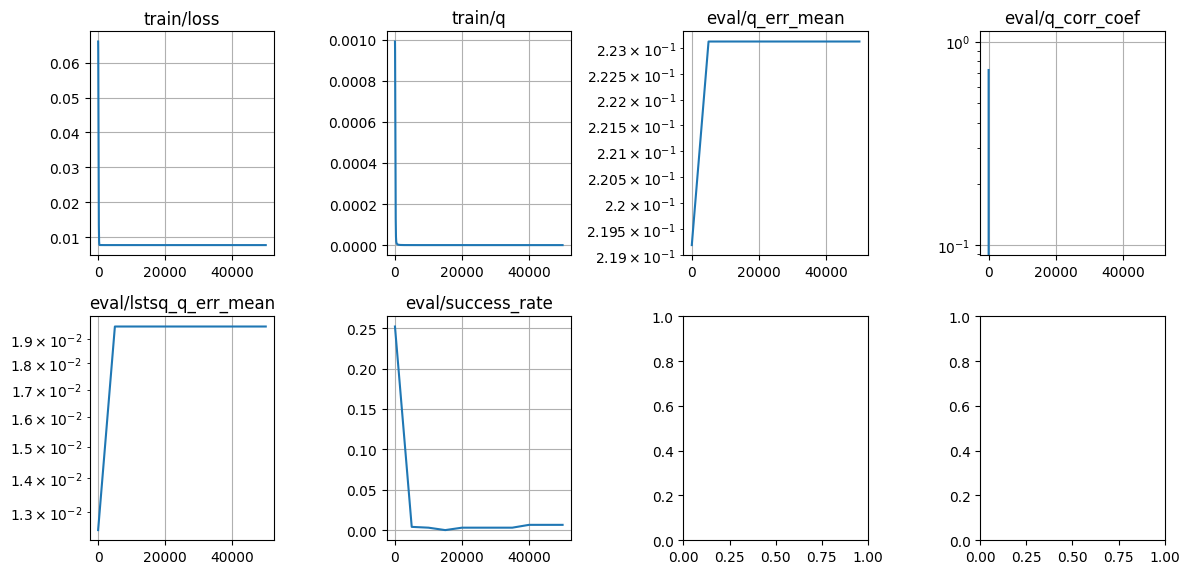

100%|██████████| 50000/50000 [03:27<00:00, 241.06it/s]


In [44]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_augmented_batch(2, p_curgoal=0.0, p_trajgoal=1.0)
critic = Critic(repr_dim=32)
critic_params = critic.init(critic_key, example_batch['observations'], example_batch['actions'], example_batch['next_observations'])

def loss_fn(params, batch):
  pos_logits = critic.apply(
    params, batch['observations'], batch['actions'], batch['goals'])
  neg_logits = critic.apply(
    params, batch['observations'], batch['actions'], batch['next_observations'])
  
  I = jnp.eye(batch_size)
  logits = I * pos_logits + (1 - I) * neg_logits
  loss = optax.sigmoid_binary_cross_entropy(logits=logits, labels=I).mean()
  
  plus_logits = critic.apply(params, batch['observations'], batch['actions'], 
                             (augmented_env.num_states - 2) * jnp.ones_like(batch['observations']))
  plus_probs = jnp.exp(jnp.diag(plus_logits)) * goal_marg[augmented_env.num_states - 2]
  q = (1 + discount) / discount * plus_probs
  
  info = {
    'loss': loss,
    'q': q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, opt_state, batch):
  (loss, info), grads = grad_fn(params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  return params, opt_state, loss, info

def compute_success_rate(params, num_eval_episodes=2000, max_episode_steps=1001):
  seed = 100
  augmented_eval_env = AugmentedRiverSwim(discount=discount, seed=seed, max_episode_steps=max_episode_steps)
  
  # compute the pi
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  plus_logits = critic.apply(params, obs, actions, 
                             (augmented_env.num_states - 2) * jnp.ones_like(obs))
  plus_logits = jnp.diag(plus_logits)
  plus_logits = plus_logits.reshape([augmented_env.num_states, augmented_env.num_actions])
  a = jnp.argmax(plus_logits, axis=-1)
  pi = jax.nn.one_hot(a, augmented_env.num_actions)
  pi = np.asarray(pi)
  
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  plus_logits = critic.apply(critic_params, obs, actions, 
                            (augmented_env.num_states - 2) * jnp.ones_like(obs))
  plus_probs = jnp.exp(jnp.diag(plus_logits)) * goal_marg[augmented_env.num_states - 2]
  q = (1 + discount) / discount * plus_probs
  q = q.reshape([augmented_env.num_states, augmented_env.num_actions])
  q = q[:env.num_states]

  # evaluation
  successes = []
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs = augmented_eval_env.reset()
    while not done:
      action = np.random.choice(np.arange(augmented_eval_env.num_actions), p=pi[obs])
      reward, next_obs, terminated, truncated = augmented_eval_env.step(action)
      done = terminated or truncated
      
      traj_dataset['observations'].append(obs)
      traj_dataset['actions'].append(action)
      traj_dataset['rewards'].append(reward)
      
      obs = next_obs
    successes.append(np.sum(traj_dataset['rewards']) >= 1.0)

  sr = np.mean(successes)

  return sr

def evaluate_fn(params):
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  plus_logits = critic.apply(params, obs, actions, 
                             (augmented_env.num_states - 2) * jnp.ones_like(obs))
  plus_probs = jnp.exp(jnp.diag(plus_logits)) * goal_marg[augmented_env.num_states - 2]
  q = (1 + discount) / discount * plus_probs
  q = q.reshape([augmented_env.num_states, augmented_env.num_actions])
  q = q[:env.num_states]
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q_square_discount.reshape(-1)
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q_square_discount))
  
  sr = compute_success_rate(params)
  # scaled_q = q * (opt_q_square_discount / q).mean()
  # q_err_mean = jnp.mean(jnp.abs(q - opt_q_square_discount))
  # scaled_q_err_mean = jnp.mean(jnp.abs(scaled_q - opt_q_square_discount))
  # q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  
  # random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  # logits = critic.apply(params, batch['observations'], batch['actions'], random_states)
  # ratios = jax.nn.softmax(logits, axis=-1) * batch_size
  # probs = jnp.diag(ratios) * s_marg[random_states]
  # prob_err_mean = jnp.mean(jnp.abs(probs - opt_d_sa[batch['observations'], batch['actions'], random_states]))
  
  info = {
    'q_err_mean': q_err_mean,
    'q_corr_coef': q_corr_coef,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'success_rate': sr,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_augmented_batch(batch_size, p_curgoal=0.0, p_trajgoal=1.0)
  critic_params, opt_state, loss, info = update_fn(
    critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/lstsq_q_err_mean', 'eval/q_corr_coef'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [45]:
crl_metrics = metrics
print(crl_metrics['eval/q_err_mean'][-1])
print(crl_metrics['eval/q_corr_coef'][-1])
print(crl_metrics['eval/lstsq_q_err_mean'][-1])
print(crl_metrics['eval/success_rate'][-1])

[5.00000000e+04 2.23133415e-01]
[ 5.00000000e+04 -1.28275454e-01]
[5.00000000e+04 1.95168965e-02]
[5.0e+04 6.5e-03]


In [46]:
# evaluation the pi
obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)

plus_logits = critic.apply(critic_params, obs, actions, 
                           (augmented_env.num_states - 2) * jnp.ones_like(obs))
plus_logits = jnp.diag(plus_logits)
plus_logits = plus_logits.reshape([augmented_env.num_states, augmented_env.num_actions])
a = jnp.argmax(plus_logits, axis=-1)
pi = jax.nn.one_hot(a, augmented_env.num_actions)
pi = np.asarray(pi)

print("pi: ")
print(pi)

pi: 
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


### SGC TD InfoNCE

In [48]:
s_marg = np.zeros(augmented_env.num_states)
for state in range(augmented_env.num_states):
    s_marg[state] = np.sum(augmented_train_dataset['next_observations'] == state) / len(augmented_train_dataset['next_observations'])
s_marg = jnp.asarray(s_marg)
print(s_marg)

[0.00611486 0.02486911 0.05628272 0.14004236 0.43419528 0.32839414
 0.00189841 0.00820311]


In [57]:
class Critic(nn.Module):
  repr_dim: int = 512

  @nn.compact
  def __call__(self, obs, action, future_obs):
    obs = jax.nn.one_hot(obs, augmented_env.num_states)
    action = jax.nn.one_hot(action, augmented_env.num_actions)
    future_obs = jax.nn.one_hot(future_obs, augmented_env.num_states)
    phi_inputs = jnp.concatenate([obs, action], axis=-1)
    psi_inputs = future_obs

    phi = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(self.repr_dim),
    ])(phi_inputs)
    psi = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(self.repr_dim),
    ])(psi_inputs)
    
    logits = jnp.einsum('ik,jk->ij', phi, psi)
    logits = logits / jnp.sqrt(self.repr_dim)
    
    return logits

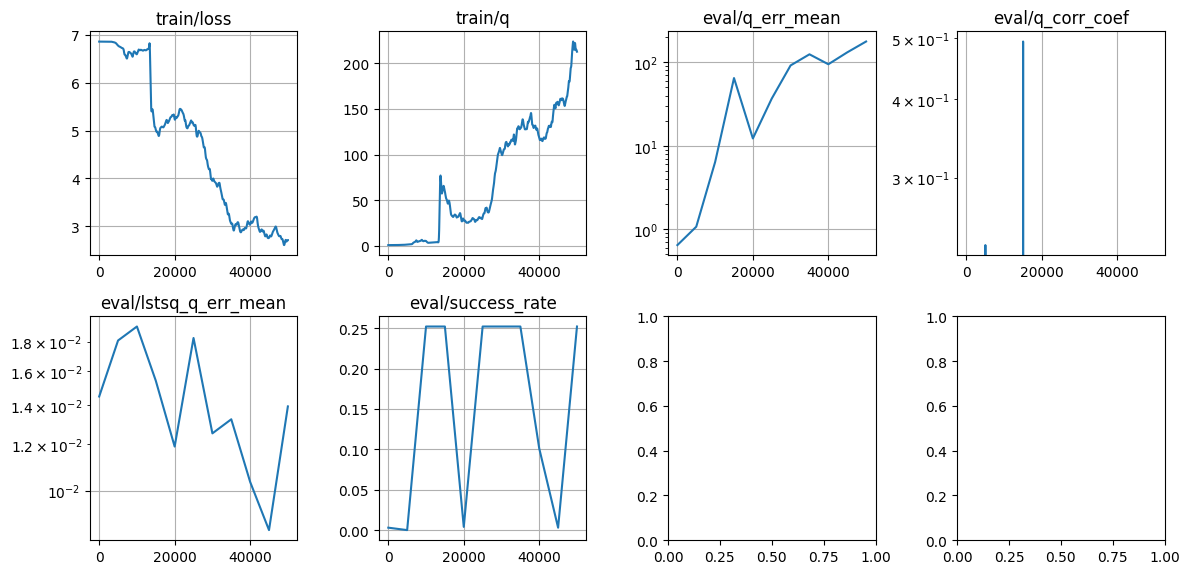

100%|██████████| 50000/50000 [03:43<00:00, 223.70it/s]


In [58]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

indicators = np.zeros((augmented_env.num_states, augmented_env.num_actions))
indicators[augmented_env.num_states - 2] = 1.
indicators = jnp.asarray(indicators)
s_plus_marg = jnp.sum(augmented_train_dataset['next_observations'] == env.num_states - 2) / len(augmented_train_dataset['next_observations'])

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_augmented_batch(2)
critic = Critic(repr_dim=32)
critic_params = critic.init(critic_key, example_batch['observations'], example_batch['actions'], example_batch['next_observations'])
target_critic_params = copy.deepcopy(critic_params)

def loss_fn(params, target_params, batch):
  logits = critic.apply(
    params, batch['observations'], batch['actions'], batch['next_observations'])
  
  random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  random_logits = critic.apply(
    params, batch['observations'], batch['actions'], random_states)
  
  I = jnp.eye(batch_size)
  logits = I * logits + (1 - I) * random_logits
  cur_loss = optax.softmax_cross_entropy(logits=logits, labels=I)
  
  future_logit1 = critic.apply(
    target_params, batch['next_observations'], jnp.zeros_like(batch['next_observations']), random_states)
  future_logit2 = critic.apply(
    target_params, batch['next_observations'], jnp.ones_like(batch['next_observations']), random_states)
  plus_logits1 = critic.apply(target_params, batch['next_observations'], jnp.zeros_like(batch['next_observations']), 
                              (augmented_env.num_states - 2) * jnp.ones_like(batch['observations']))
  plus_logits2 = critic.apply(target_params, batch['next_observations'], jnp.ones_like(batch['next_observations']), 
                              (augmented_env.num_states - 2) * jnp.ones_like(batch['observations']))
  plus_log_probs1 = jnp.diag(plus_logits1) - jax.nn.logsumexp(future_logit1, axis=-1)
  plus_log_probs2 = jnp.diag(plus_logits2) - jax.nn.logsumexp(future_logit2, axis=-1)
  plus_log_probs = jnp.stack([plus_log_probs1, plus_log_probs2], axis=-1)
  next_actions = jnp.argmax(plus_log_probs, axis=-1)
  next_actions = jax.lax.stop_gradient(next_actions)
  
  w_logits = critic.apply(
    target_params, batch['next_observations'], next_actions, random_states)
  w = jax.nn.softmax(w_logits, axis=-1)
  w = jax.lax.stop_gradient(w) * batch_size * I
  # w = jnp.clip(w, 0.0, 100.0 / batch_size)
  
  future_loss = optax.softmax_cross_entropy(logits=random_logits, labels=w)
  
  loss = (1 - discount) * cur_loss + discount * batch['masks'] * future_loss
  loss = jnp.mean(loss)
  
  plus_logits = critic.apply(params, batch['observations'], batch['actions'], 
                             (augmented_env.num_states - 2) * jnp.ones_like(batch['observations']))
  plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(random_logits, axis=-1)
  probs = jnp.exp(plus_log_probs) * batch_size * s_plus_marg
  scaled_probs = discount * probs + (1 - discount) * indicators[batch['observations'], batch['actions']]
  q = scaled_probs * (1 + discount) / discount
  
  info = {
    'loss': loss,
    'q': q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def compute_success_rate(params, batch, num_eval_episodes=2000, max_episode_steps=1001):
  seed = 100
  augmented_eval_env = AugmentedRiverSwim(discount=discount, seed=seed, max_episode_steps=max_episode_steps)
  
  # compute the pi
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  # plus_logits = critic.apply(params, obs, actions, 
  #                            (augmented_env.num_states - 2) * jnp.ones_like(obs))
  # plus_logits = jnp.diag(plus_logits)
  # plus_logits = plus_logits.reshape([augmented_env.num_states, augmented_env.num_actions])
  random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  plus_logits = critic.apply(params, obs, actions, 
                             (augmented_env.num_states - 2) * jnp.ones_like(random_states))
  random_logits = critic.apply(params, obs, actions, random_states)
  plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(random_logits, axis=-1)
  plus_log_probs = plus_log_probs.reshape([augmented_env.num_states, augmented_env.num_actions])
  
  a = jnp.argmax(plus_log_probs, axis=-1)
  pi = jax.nn.one_hot(a, augmented_env.num_actions)
  pi = np.asarray(pi)
  
  # evaluation
  successes = []
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs = augmented_eval_env.reset()
    while not done:
      action = np.random.choice(np.arange(augmented_eval_env.num_actions), p=pi[obs])
      reward, next_obs, terminated, truncated = augmented_eval_env.step(action)
      done = terminated or truncated
      
      traj_dataset['observations'].append(obs)
      traj_dataset['actions'].append(action)
      traj_dataset['rewards'].append(reward)
      
      obs = next_obs
    successes.append(np.sum(traj_dataset['rewards']) >= 1.0)

  sr = np.mean(successes)

  return sr

def evaluate_fn(params, batch):
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  plus_logits = critic.apply(params, obs, actions, 
                             (augmented_env.num_states - 2) * jnp.ones_like(random_states))
  random_logits = critic.apply(params, obs, actions, random_states)
  plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(random_logits, axis=-1)
  plus_probs = jnp.exp(plus_log_probs) * batch_size * s_plus_marg
  plus_probs = plus_probs.reshape([augmented_env.num_states, augmented_env.num_actions])
  scaled_plus_probs = discount * plus_probs + (1 - discount) * indicators
  q = scaled_plus_probs * (1 + discount) / discount
  q = q[:env.num_states]
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q_square_discount.reshape(-1)
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q_square_discount))
  
  sr = compute_success_rate(params, batch)
  
  # random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  # logits = critic.apply(params, batch['observations'], batch['actions'], random_states)
  # ratios = jax.nn.softmax(logits, axis=-1) * batch_size
  # probs = jnp.diag(ratios) * s_marg[random_states]
  # prob_err_mean = jnp.mean(jnp.abs(probs - opt_d_sa[batch['observations'], batch['actions'], random_states]))
  
  info = {
    'q_err_mean': q_err_mean,
    'q_corr_coef': q_corr_coef,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'success_rate': sr,
    # 'prob_err_mean': prob_err_mean,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_augmented_batch(batch_size)
  critic_params, target_critic_params, opt_state, loss, info = update_fn(
    critic_params, target_critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params, batch)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/lstsq_q_err_mean', 'eval/q_corr_coef'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [ ]:
sgc_td_infonce_metrics = metrics
print(sgc_td_infonce_metrics['eval/q_err_mean'][-1])
print(sgc_td_infonce_metrics['eval/q_corr_coef'][-1])
print(sgc_td_infonce_metrics['eval/lstsq_q_err_mean'][-1])
print(sgc_td_infonce_metrics['eval/success_rate'][-1])

[5.00000000e+04 5.03382802e-01]
[5.00000000e+04 9.86773908e-01]
[5.00000000e+04 3.15719983e-03]
[5.00e+04 2.52e-01]


In [ ]:
# evaluation the pi
batch = sample_augmented_batch(batch_size)

obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
random_states = jnp.roll(batch['observations'], -1, axis=0)
plus_logits = critic.apply(critic_params, obs, actions, 
                            (augmented_env.num_states - 2) * jnp.ones_like(random_states))
random_logits = critic.apply(critic_params, obs, actions, random_states)
plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(random_logits, axis=-1)
plus_log_probs = plus_log_probs.reshape([augmented_env.num_states, augmented_env.num_actions])

a = jnp.argmax(plus_log_probs, axis=-1)
pi = jax.nn.one_hot(a, augmented_env.num_actions)
pi = np.asarray(pi)

print("pi: ")
print(pi)

### GC TD InfoNCE

In [77]:
class Critic(nn.Module):
  repr_dim: int = 512

  @nn.compact
  def __call__(self, obs, action, goals, future_obs):
    obs = jax.nn.one_hot(obs, augmented_env.num_states)
    action = jax.nn.one_hot(action, augmented_env.num_actions)
    goals = jax.nn.one_hot(goals, augmented_env.num_states)
    future_obs = jax.nn.one_hot(future_obs, augmented_env.num_states)
    phi_inputs = jnp.concatenate([obs, action, goals], axis=-1)
    psi_inputs = future_obs

    phi = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(self.repr_dim),
    ])(phi_inputs)
    psi = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(self.repr_dim),
    ])(psi_inputs)
    
    logits = jnp.einsum('ik,jk->ij', phi, psi)
    logits = logits / jnp.sqrt(self.repr_dim)
    
    return logits

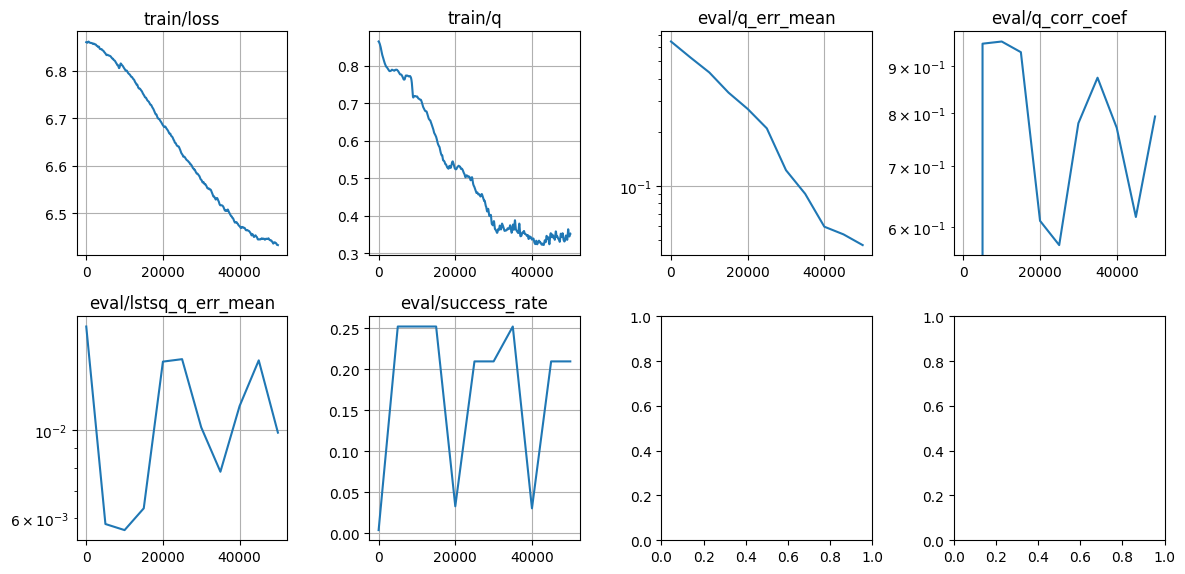

100%|██████████| 50000/50000 [03:43<00:00, 223.63it/s]


In [ ]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

indicators = np.zeros((augmented_env.num_states, augmented_env.num_actions))
indicators[augmented_env.num_states - 2] = 1.
indicators = jnp.asarray(indicators)
s_plus_marg = jnp.sum(augmented_train_dataset['next_observations'] == env.num_states - 2) / len(augmented_train_dataset['next_observations'])

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_augmented_batch(2)
critic = Critic(repr_dim=16)
critic_params = critic.init(critic_key, 
                            example_batch['observations'], example_batch['actions'], 
                            example_batch['goals'], example_batch['next_observations'])
target_critic_params = copy.deepcopy(critic_params)

def loss_fn(params, target_params, batch):
  logits = critic.apply(
    params, batch['observations'], batch['actions'], batch['goals'], batch['next_observations'])
  
  random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  random_logits = critic.apply(
    params, batch['observations'], batch['actions'], batch['goals'], random_states)
  
  I = jnp.eye(batch_size)
  logits = I * logits + (1 - I) * random_logits
  cur_loss = optax.softmax_cross_entropy(logits=logits, labels=I)
  
  future_logit1 = critic.apply(
    target_params, batch['next_observations'], jnp.zeros_like(batch['next_observations']), batch['goals'], random_states)
  future_logit2 = critic.apply(
    target_params, batch['next_observations'], jnp.ones_like(batch['next_observations']), batch['goals'], random_states)
  plus_logits1 = critic.apply(target_params, batch['next_observations'], jnp.zeros_like(batch['next_observations']), 
                              batch['goals'], batch['goals'])
  plus_logits2 = critic.apply(target_params, batch['next_observations'], jnp.ones_like(batch['next_observations']), 
                              batch['goals'], batch['goals'])
  plus_log_probs1 = jnp.diag(plus_logits1) - jax.nn.logsumexp(future_logit1, axis=-1)
  plus_log_probs2 = jnp.diag(plus_logits2) - jax.nn.logsumexp(future_logit2, axis=-1)
  plus_log_probs = jnp.stack([plus_log_probs1, plus_log_probs2], axis=-1)
  next_actions = jnp.argmax(plus_log_probs, axis=-1)
  next_actions = jax.lax.stop_gradient(next_actions)
  
  w_logits = critic.apply(
    target_params, batch['next_observations'], next_actions, batch['goals'], random_states)
  w = jax.nn.softmax(w_logits, axis=-1)
  w = jax.lax.stop_gradient(w)
  # w = jnp.clip(w, 0.0, 100.0 / batch_size)
  
  future_loss = optax.softmax_cross_entropy(logits=random_logits, labels=w)
  
  loss = (1 - discount) * cur_loss + discount * batch['masks'] * future_loss
  loss = jnp.mean(loss)
  
  plus_logits = critic.apply(params, batch['observations'], batch['actions'], 
                             (augmented_env.num_states - 2) * jnp.ones_like(batch['observations']),
                             (augmented_env.num_states - 2) * jnp.ones_like(batch['observations']))
  random_logits = critic.apply(params, batch['observations'], batch['actions'],
                               (augmented_env.num_states - 2) * jnp.ones_like(batch['observations']),
                               random_states)
  plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(random_logits, axis=-1)
  probs = jnp.exp(plus_log_probs) * batch_size * s_plus_marg
  scaled_probs = discount * probs + (1 - discount) * indicators[batch['observations'], batch['actions']]
  q = scaled_probs * (1 + discount) / discount
  
  info = {
    'loss': loss,
    'q': q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def compute_success_rate(params, batch, num_eval_episodes=2000, max_episode_steps=1001):
  seed = 100
  augmented_eval_env = AugmentedRiverSwim(discount=discount, seed=seed, max_episode_steps=max_episode_steps)
  
  # compute the pi
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  # plus_logits = critic.apply(params, obs, actions, 
  #                            (augmented_env.num_states - 2) * jnp.ones_like(obs))
  # plus_logits = jnp.diag(plus_logits)
  # plus_logits = plus_logits.reshape([augmented_env.num_states, augmented_env.num_actions])
  random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  plus_logits = critic.apply(params, obs, actions, 
                             (augmented_env.num_states - 2) * jnp.ones_like(obs),
                             (augmented_env.num_states - 2) * jnp.ones_like(obs))
  random_logits = critic.apply(params, obs, actions, 
                               (augmented_env.num_states - 2) * jnp.ones_like(obs),
                               random_states)
  plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(random_logits, axis=-1)
  plus_log_probs = plus_log_probs.reshape([augmented_env.num_states, augmented_env.num_actions])
  
  a = jnp.argmax(plus_log_probs, axis=-1)
  pi = jax.nn.one_hot(a, augmented_env.num_actions)
  pi = np.asarray(pi)
  
  # evaluation
  successes = []
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs = augmented_eval_env.reset()
    while not done:
      action = np.random.choice(np.arange(augmented_eval_env.num_actions), p=pi[obs])
      reward, next_obs, terminated, truncated = augmented_eval_env.step(action)
      done = terminated or truncated
      
      traj_dataset['observations'].append(obs)
      traj_dataset['actions'].append(action)
      traj_dataset['rewards'].append(reward)
      
      obs = next_obs
    successes.append(np.sum(traj_dataset['rewards']) >= 1.0)

  sr = np.mean(successes)

  return sr

def evaluate_fn(params, batch):
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  plus_logits = critic.apply(params, obs, actions,
                             (augmented_env.num_states - 2) * jnp.ones_like(obs), 
                             (augmented_env.num_states - 2) * jnp.ones_like(obs))
  random_logits = critic.apply(params, obs, actions, 
                               (augmented_env.num_states - 2) * jnp.ones_like(obs),
                               random_states)
  plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(random_logits, axis=-1)
  plus_probs = jnp.exp(plus_log_probs) * batch_size * s_plus_marg
  plus_probs = plus_probs.reshape([augmented_env.num_states, augmented_env.num_actions])
  scaled_plus_probs = discount * plus_probs + (1 - discount) * indicators
  q = scaled_plus_probs * (1 + discount) / discount
  q = q[:env.num_states]
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q_square_discount.reshape(-1)
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q_square_discount))
  
  sr = compute_success_rate(params, batch)
  
  # random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  # logits = critic.apply(params, batch['observations'], batch['actions'], random_states)
  # ratios = jax.nn.softmax(logits, axis=-1) * batch_size
  # probs = jnp.diag(ratios) * s_marg[random_states]
  # prob_err_mean = jnp.mean(jnp.abs(probs - opt_d_sa[batch['observations'], batch['actions'], random_states]))
  
  info = {
    'q_err_mean': q_err_mean,
    'q_corr_coef': q_corr_coef,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'success_rate': sr,
    # 'prob_err_mean': prob_err_mean,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_augmented_batch(batch_size)
  critic_params, target_critic_params, opt_state, loss, info = update_fn(
    critic_params, target_critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params, batch)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/lstsq_q_err_mean', 'eval/q_corr_coef'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [79]:
td_infonce_metrics = metrics
print(td_infonce_metrics['eval/q_err_mean'][-1])
print(td_infonce_metrics['eval/q_corr_coef'][-1])
print(td_infonce_metrics['eval/lstsq_q_err_mean'][-1])
print(td_infonce_metrics['eval/success_rate'][-1])

[5.00000000e+04 4.66303192e-02]
[5.00000000e+04 7.92821169e-01]
[5.00000000e+04 9.83698945e-03]
[5.000e+04 2.095e-01]


### SGCQL + data augmentation

In [176]:
sample_batch(2)

{'actions': array([0, 1], dtype=int32),
 'masks': array([1., 1.], dtype=float32),
 'next_actions': array([0, 1], dtype=int32),
 'next_observations': array([1, 2], dtype=int32),
 'observations': array([2, 3], dtype=int32),
 'rewards': array([0., 0.], dtype=float32),
 'terminals': array([0., 0.], dtype=float32)}

In [207]:
def augment_batch(batch):
    aug_batch = batch['observations']
    
    is_splus = np.random.rand() < batch['rewards']
    aug_next_observations = np.where(
        is_splus,
        augmented_env.num_states - 2,
        augmented_env.num_states - 1,
    )
    aug_rewards = np.where(
        is_splus,
        np.ones_like(batch['rewards']),
        np.zeros_like(batch['rewards']),
    )
    aug_masks = np.zeros_like(aug_next_observations)
    
    batch['rewards'][:] = 0.0
    aug_batch = jax.tree_util.tree_map(lambda arr: arr.copy(), batch)
    aug_batch['next_observations'] = aug_next_observations
    aug_batch['rewards'] = aug_rewards
    aug_batch['masks'] = aug_masks
    
    aug_batch = jax.tree_util.tree_map(
        lambda arr1, arr2: np.concatenate([arr1, arr2], axis=0), 
        batch, 
        aug_batch
    )
    
    return aug_batch

In [208]:
class Critic(nn.Module):
  @nn.compact
  def __call__(self, obs, action):
    obs = jax.nn.one_hot(obs, augmented_env.num_states)
    action = jax.nn.one_hot(action, augmented_env.num_actions)
    inputs = jnp.concatenate([obs, action], axis=-1)
    
    qs = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(1),
    ])(inputs)
    
    qs = qs.squeeze(-1)

    return qs

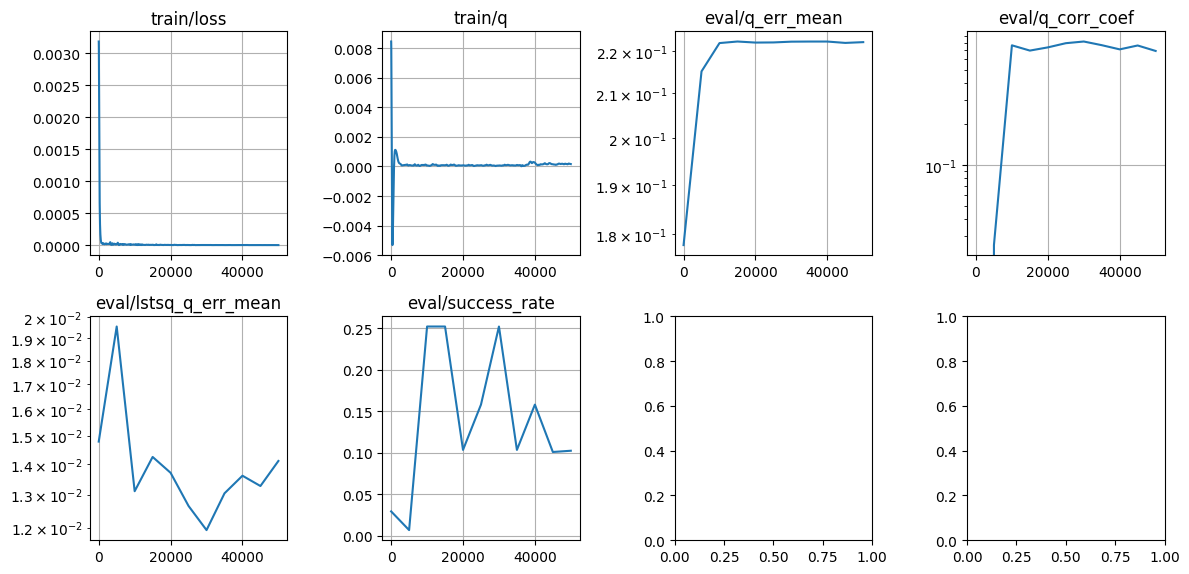

100%|██████████| 50000/50000 [02:44<00:00, 303.58it/s]


In [209]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

indicators = np.zeros((augmented_env.num_states, augmented_env.num_actions))
indicators[augmented_env.num_states - 2] = 1.
indicators = jnp.asarray(indicators)

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_batch(2)
example_batch = augment_batch(example_batch)
critic = Critic()
critic_params = critic.init(critic_key, example_batch['observations'], example_batch['actions'])
target_critic_params = copy.deepcopy(critic_params)

def loss_fn(params, target_params, batch):
  q = critic.apply(params, batch['observations'], batch['actions'])
  
  next_q1 = critic.apply(target_params, batch['next_observations'], jnp.zeros_like(batch['next_observations']))
  next_q2 = critic.apply(target_params, batch['next_observations'], jnp.ones_like(batch['next_observations']))
  next_q = jnp.maximum(next_q1, next_q2)
  target_q = (1 - discount) * batch['rewards'] + discount * batch['masks'] * next_q

  loss = jnp.mean((q - target_q) ** 2)
  
  scaled_q = q * discount + indicators[batch['observations'], batch['actions']] * (1 - discount)
  scaled_q = scaled_q * (1 + discount) / discount
  
  info = {
    'loss': loss,
    'q': scaled_q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def compute_success_rate(params, num_eval_episodes=2000, max_episode_steps=1001):
  seed = 100
  augmented_eval_env = AugmentedRiverSwim(discount=discount, seed=seed, max_episode_steps=max_episode_steps)
  
  # compute the pi
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  q = critic.apply(params, obs, actions)
  q = q.reshape([augmented_env.num_states, augmented_env.num_actions])
  a = jnp.argmax(q, axis=-1)
  pi = jax.nn.one_hot(a, augmented_env.num_actions)
  pi = np.asarray(pi)

  # evaluation
  successes = []
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs = augmented_eval_env.reset()
    while not done:
      action = np.random.choice(np.arange(augmented_eval_env.num_actions), p=pi[obs])
      reward, next_obs, terminated, truncated = augmented_eval_env.step(action)
      done = terminated or truncated
      
      traj_dataset['observations'].append(obs)
      traj_dataset['actions'].append(action)
      traj_dataset['rewards'].append(reward)
      
      obs = next_obs
    successes.append(np.sum(traj_dataset['rewards']) >= 1.0)

  sr = np.mean(successes)

  return sr

def evaluate_fn(params):
  obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
  actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
  gc_q = critic.apply(params, obs, actions)
  gc_q = gc_q.reshape([augmented_env.num_states, augmented_env.num_actions])
  # q = gc_q[:env.num_states]
  # q = q * (1 + discount) / discount
  scaled_gc_q = gc_q * discount + indicators * (1 - discount)
  scaled_gc_q = scaled_gc_q * (1 + discount) / discount
  q = scaled_gc_q[:env.num_states]
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q_square_discount.reshape(-1)
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q_square_discount))
  
  sr = compute_success_rate(params)
  
  info = {
    'q_err_mean': q_err_mean,
    'q_corr_coef': q_corr_coef,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'success_rate': sr,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_batch(batch_size)
  aug_batch = augment_batch(batch)
  critic_params, target_critic_params, opt_state, loss, info = update_fn(
    critic_params, target_critic_params, opt_state, aug_batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/q_corr_coef', 'eval/lstsq_q_err_mean'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [210]:
sgcql_data_aug_metrics = metrics
print(sgcql_data_aug_metrics['eval/q_err_mean'][-1])
print(sgcql_data_aug_metrics['eval/q_corr_coef'][-1])
print(sgcql_data_aug_metrics['eval/lstsq_q_err_mean'][-1])
print(sgcql_data_aug_metrics['eval/success_rate'][-1])

[5.00000000e+04 2.22135484e-01]
[5.00000000e+04 6.93751454e-01]
[5.00000000e+04 1.41059104e-02]
[5.000e+04 1.025e-01]


In [211]:
# evaluation the pi
obs = jnp.arange(augmented_env.num_states)[:, None].repeat(augmented_env.num_actions, axis=1).reshape(-1)
actions = jnp.arange(augmented_env.num_actions)[None, :].repeat(augmented_env.num_states, axis=0).reshape(-1)
gc_q = critic.apply(critic_params, obs, actions)
gc_q = gc_q.reshape([augmented_env.num_states, augmented_env.num_actions])
gc_a = jnp.argmax(gc_q, axis=-1)
pi = jax.nn.one_hot(gc_a, augmented_env.num_actions)
pi = np.asarray(pi)

print("pi: ")
print(pi)


pi: 
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


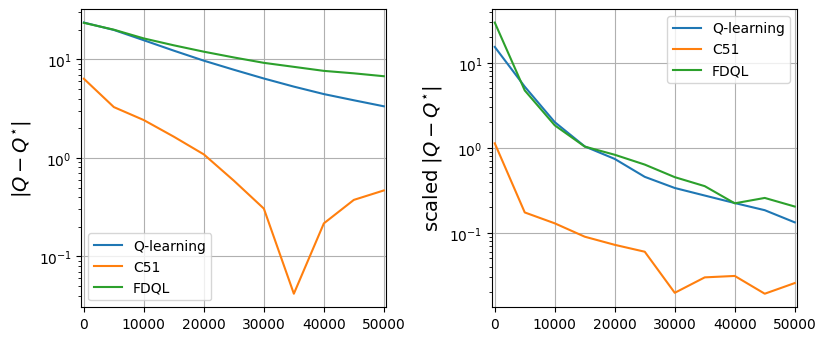

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3.2))

metric_name = 'eval/q_err_mean'
ax = axes[0]
for algo, metrics in zip(['Q-learning', 'C51', 'FDQL'], [q_learning_metrics, c51_metrics, fdql_metrics]):
    metrcs_arr = np.asarray(metrics[metric_name])
    l, = ax.plot(metrcs_arr[:, 0], metrcs_arr[:, 1], label=algo, zorder=3)
ax.set_ylabel(r'$| Q - Q^{\star} |$', fontsize=14)
ax.set_xlim([-4e2, 5e4 + 4e2])
ax.set_yscale('log')
ax.legend()
ax.grid(zorder=3)

metric_name = 'eval/scaled_q_err_mean'
ax = axes[1]
for algo, metrics in zip(['Q-learning', 'C51', 'FDQL'], [q_learning_metrics, c51_metrics, fdql_metrics]):
    metrcs_arr = np.asarray(metrics[metric_name])
    l, = ax.plot(metrcs_arr[:, 0], metrcs_arr[:, 1], label=algo, zorder=3)
ax.set_ylabel(r'scaled $| Q - Q^{\star} |$', fontsize=14)
ax.set_xlim([-4e2, 5e4 + 4e2])
ax.set_yscale('log')
ax.legend()

# ax.set_ylim([-5, 120 + 5])
# ax.set_yticks([0, 120])
# ax.yaxis.set_minor_locator(MultipleLocator(100))
ax.grid(zorder=3)     

fig.tight_layout(rect=(-0.026, -0.06, 1.02, 1.04))  # rect = (left, bottom, right, top), default: (0, 0, 1, 1)
# filepath = "/u/cz8792/research/ogbench/plot_scripts/figures/convergence_speed_ablation_lc.pdf"
# fig.savefig(filepath, dpi=150, bbox_inches="tight")
plt.show()
